In [1]:
import os
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb 
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from tpot.builtins import StackingEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from mpl_toolkits.mplot3d import Axes3D

sns.set_style('white')
np.random.seed(42)
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=UserWarning)
sklearn.set_config(print_changed_only=True)

In [2]:
result_dic = {}
models = {}

In [3]:
train_path = 'input/inputTrain.csv'
train_df = pd.read_csv(train_path)
train_df.drop(columns=['Unnamed: 0', 'carid'], inplace=True)
train_df.T

,0,1,2,3,4,5,6,7,8,9,...,29989,29990,29991,29992,29993,29994,29995,29996,29997,29998
tradeTime,0.840336,0.827731,0.802521,0.844538,0.848739,0.756303,0.789916,0.920168,0.974790,0.718487,...,0.802521,-0.655462,0.873950,0.235294,0.546218,0.701681,-0.798319,-0.310924,-0.130252,-0.012605
mileage,-0.534415,0.315772,1.028558,-0.089701,-0.154414,0.810883,0.082312,-0.379565,1.083441,-0.204128,...,-0.637535,-0.402953,0.100099,0.056000,-0.136970,0.538139,0.680581,0.478198,0.441610,-0.558113
color_1,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
color_2,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
color_3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l6,0.668317,-0.049505,-0.222772,1.074257,0.574257,-0.198020,0.222772,-0.148515,-0.143564,-0.173267,...,0.985149,0.841584,-0.074257,0.970297,1.014851,0.396040,-0.049505,0.099010,-0.198020,-0.168317
l7,-1.175993,-0.271037,-0.715401,-0.235116,-0.813323,-1.280552,-1.730886,-0.130919,-0.499289,-0.334701,...,0.454206,0.105606,-0.430253,0.416118,0.167502,-1.196486,0.693357,-0.568485,0.480517,0.405306
l8,-0.247441,-0.252904,-0.604505,0.635244,-0.169895,-0.937574,-0.769392,-0.273900,-0.481734,-0.475091,...,0.941090,0.705644,-0.333004,0.940380,0.847939,-0.369935,0.270279,-0.047498,0.040985,-0.002290
l9,0.229515,-0.226296,-0.531781,0.918661,0.311352,-0.627546,-0.475458,-0.273810,-0.352787,-0.290792,...,1.062477,0.741570,-0.313537,1.007418,0.964963,-0.112968,0.009225,-0.362698,-0.199016,-0.164260


In [4]:
X = train_df.drop(columns='price').to_numpy()
y = train_df['price'].values

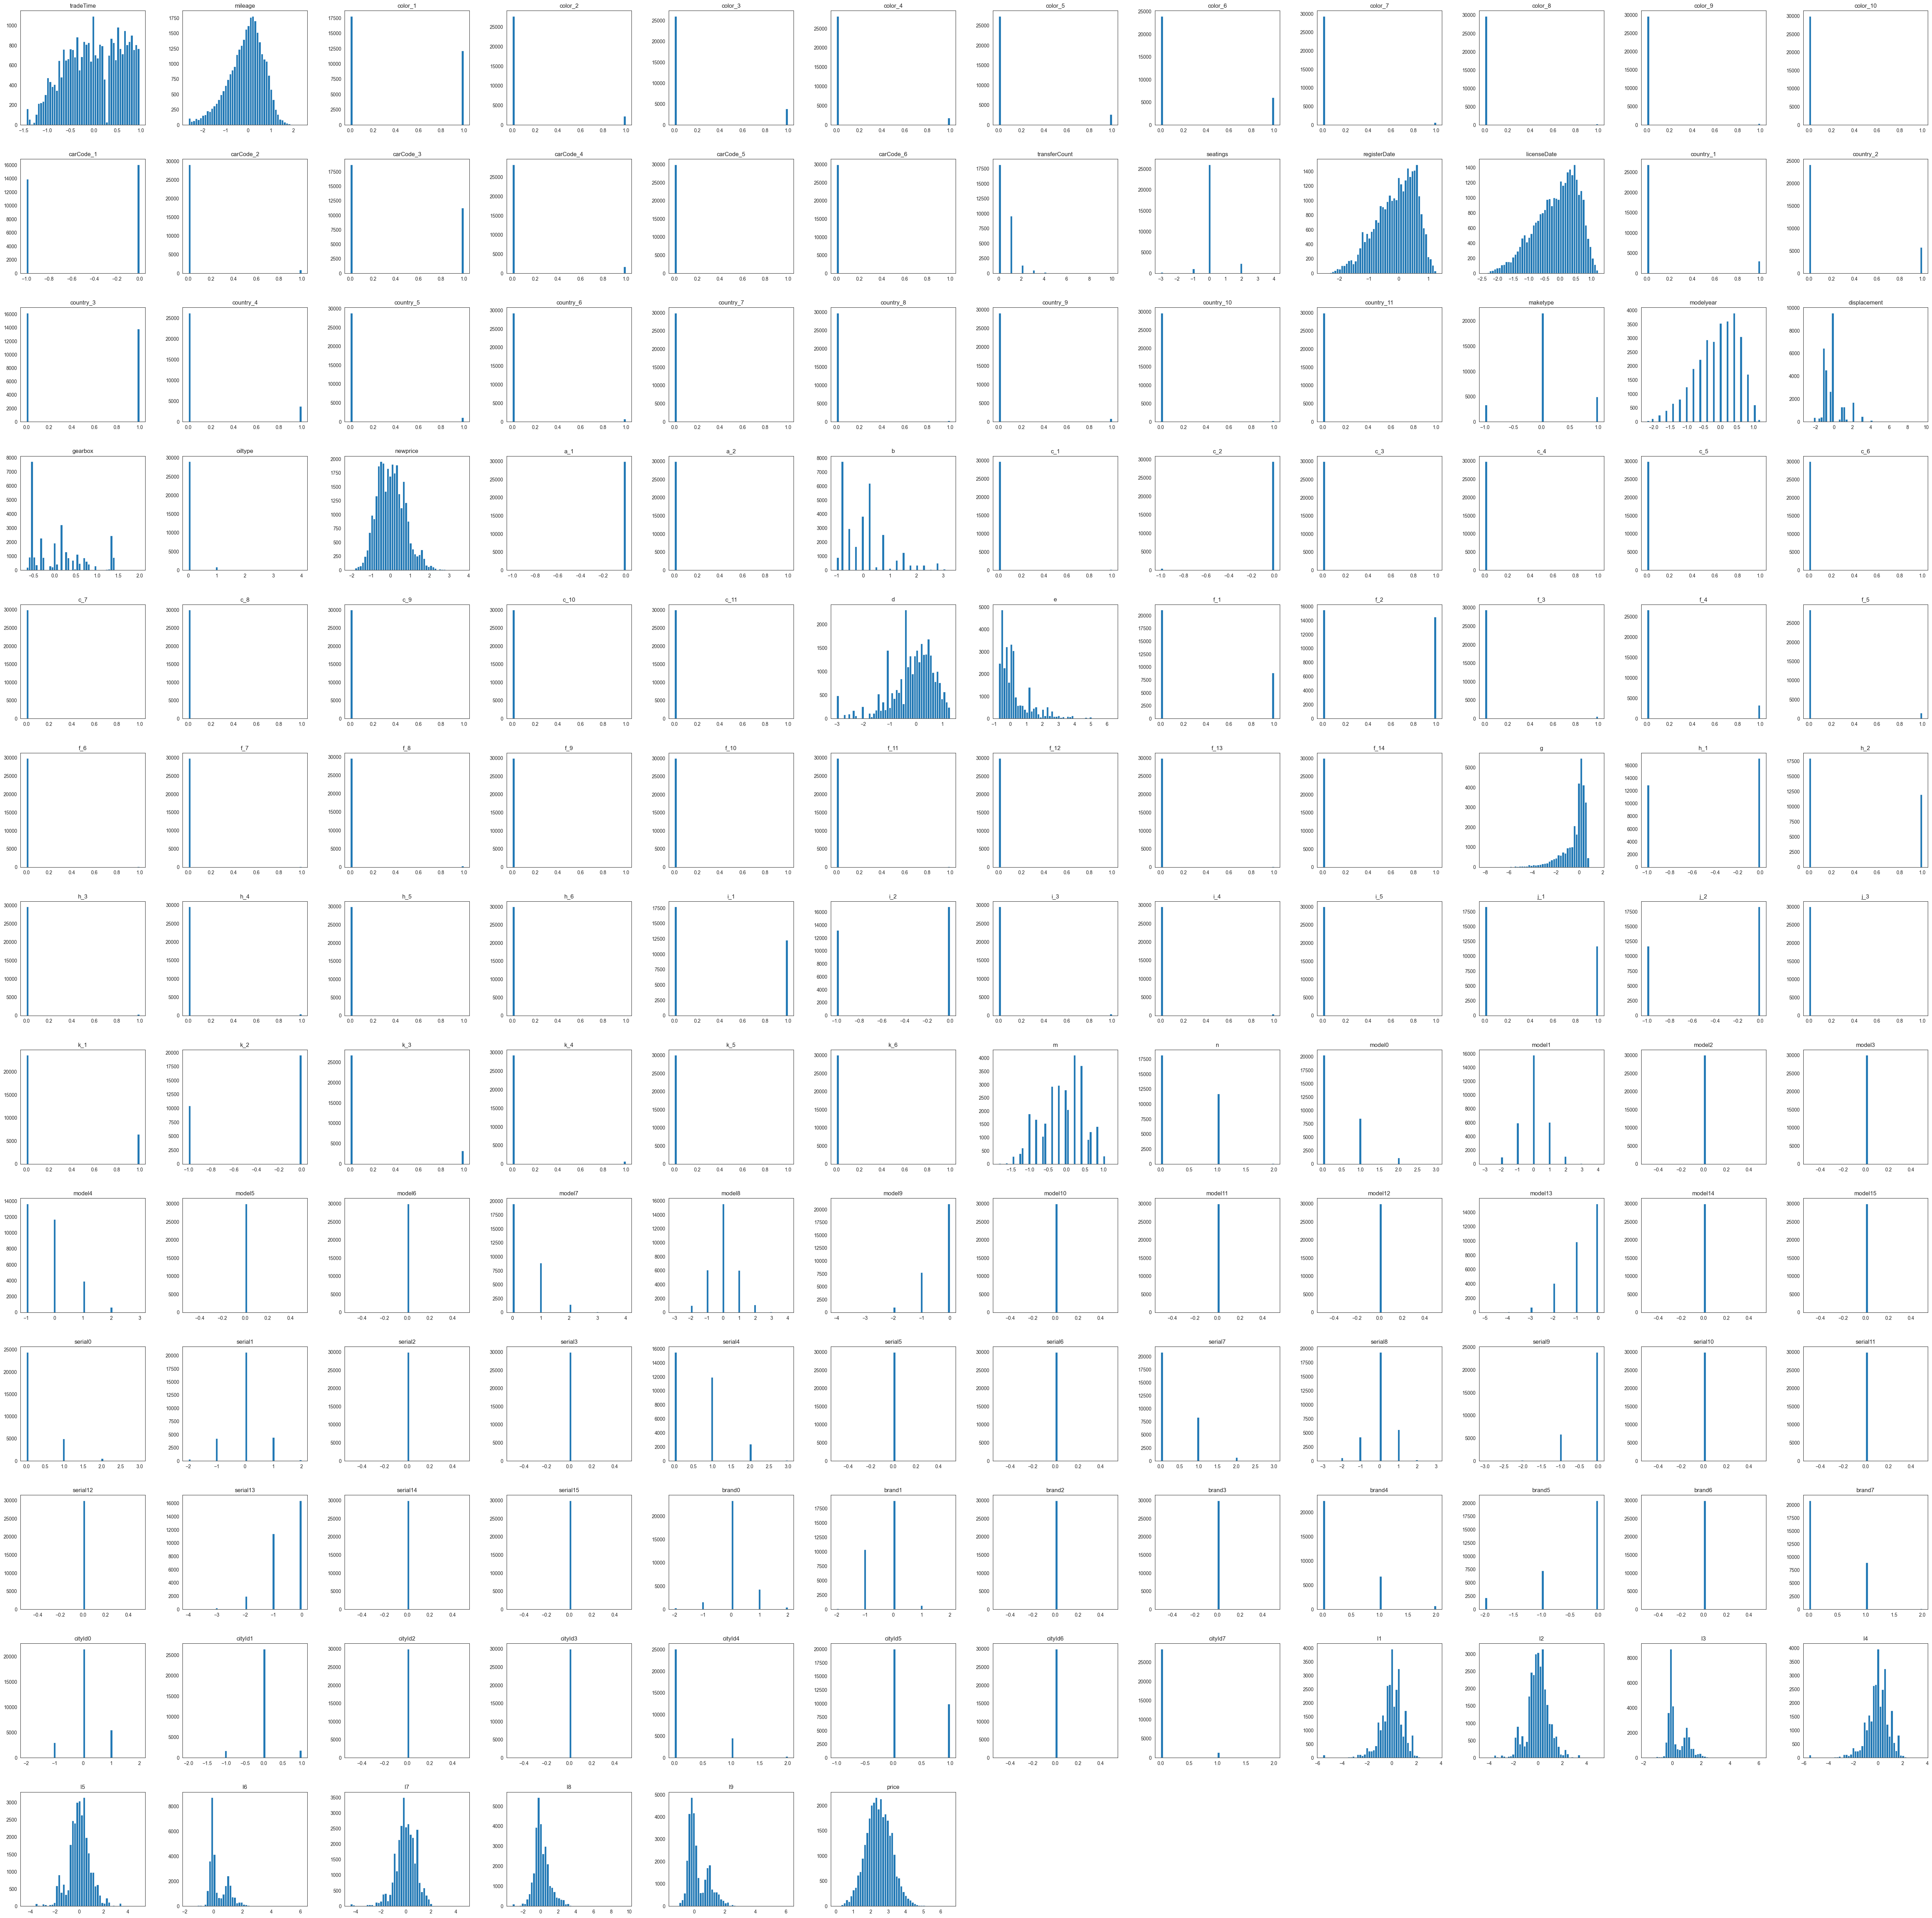

In [5]:
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
_ = train_df.hist(column=train_df.columns, grid=False, figsize = (70, 70), bins=num_bins)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

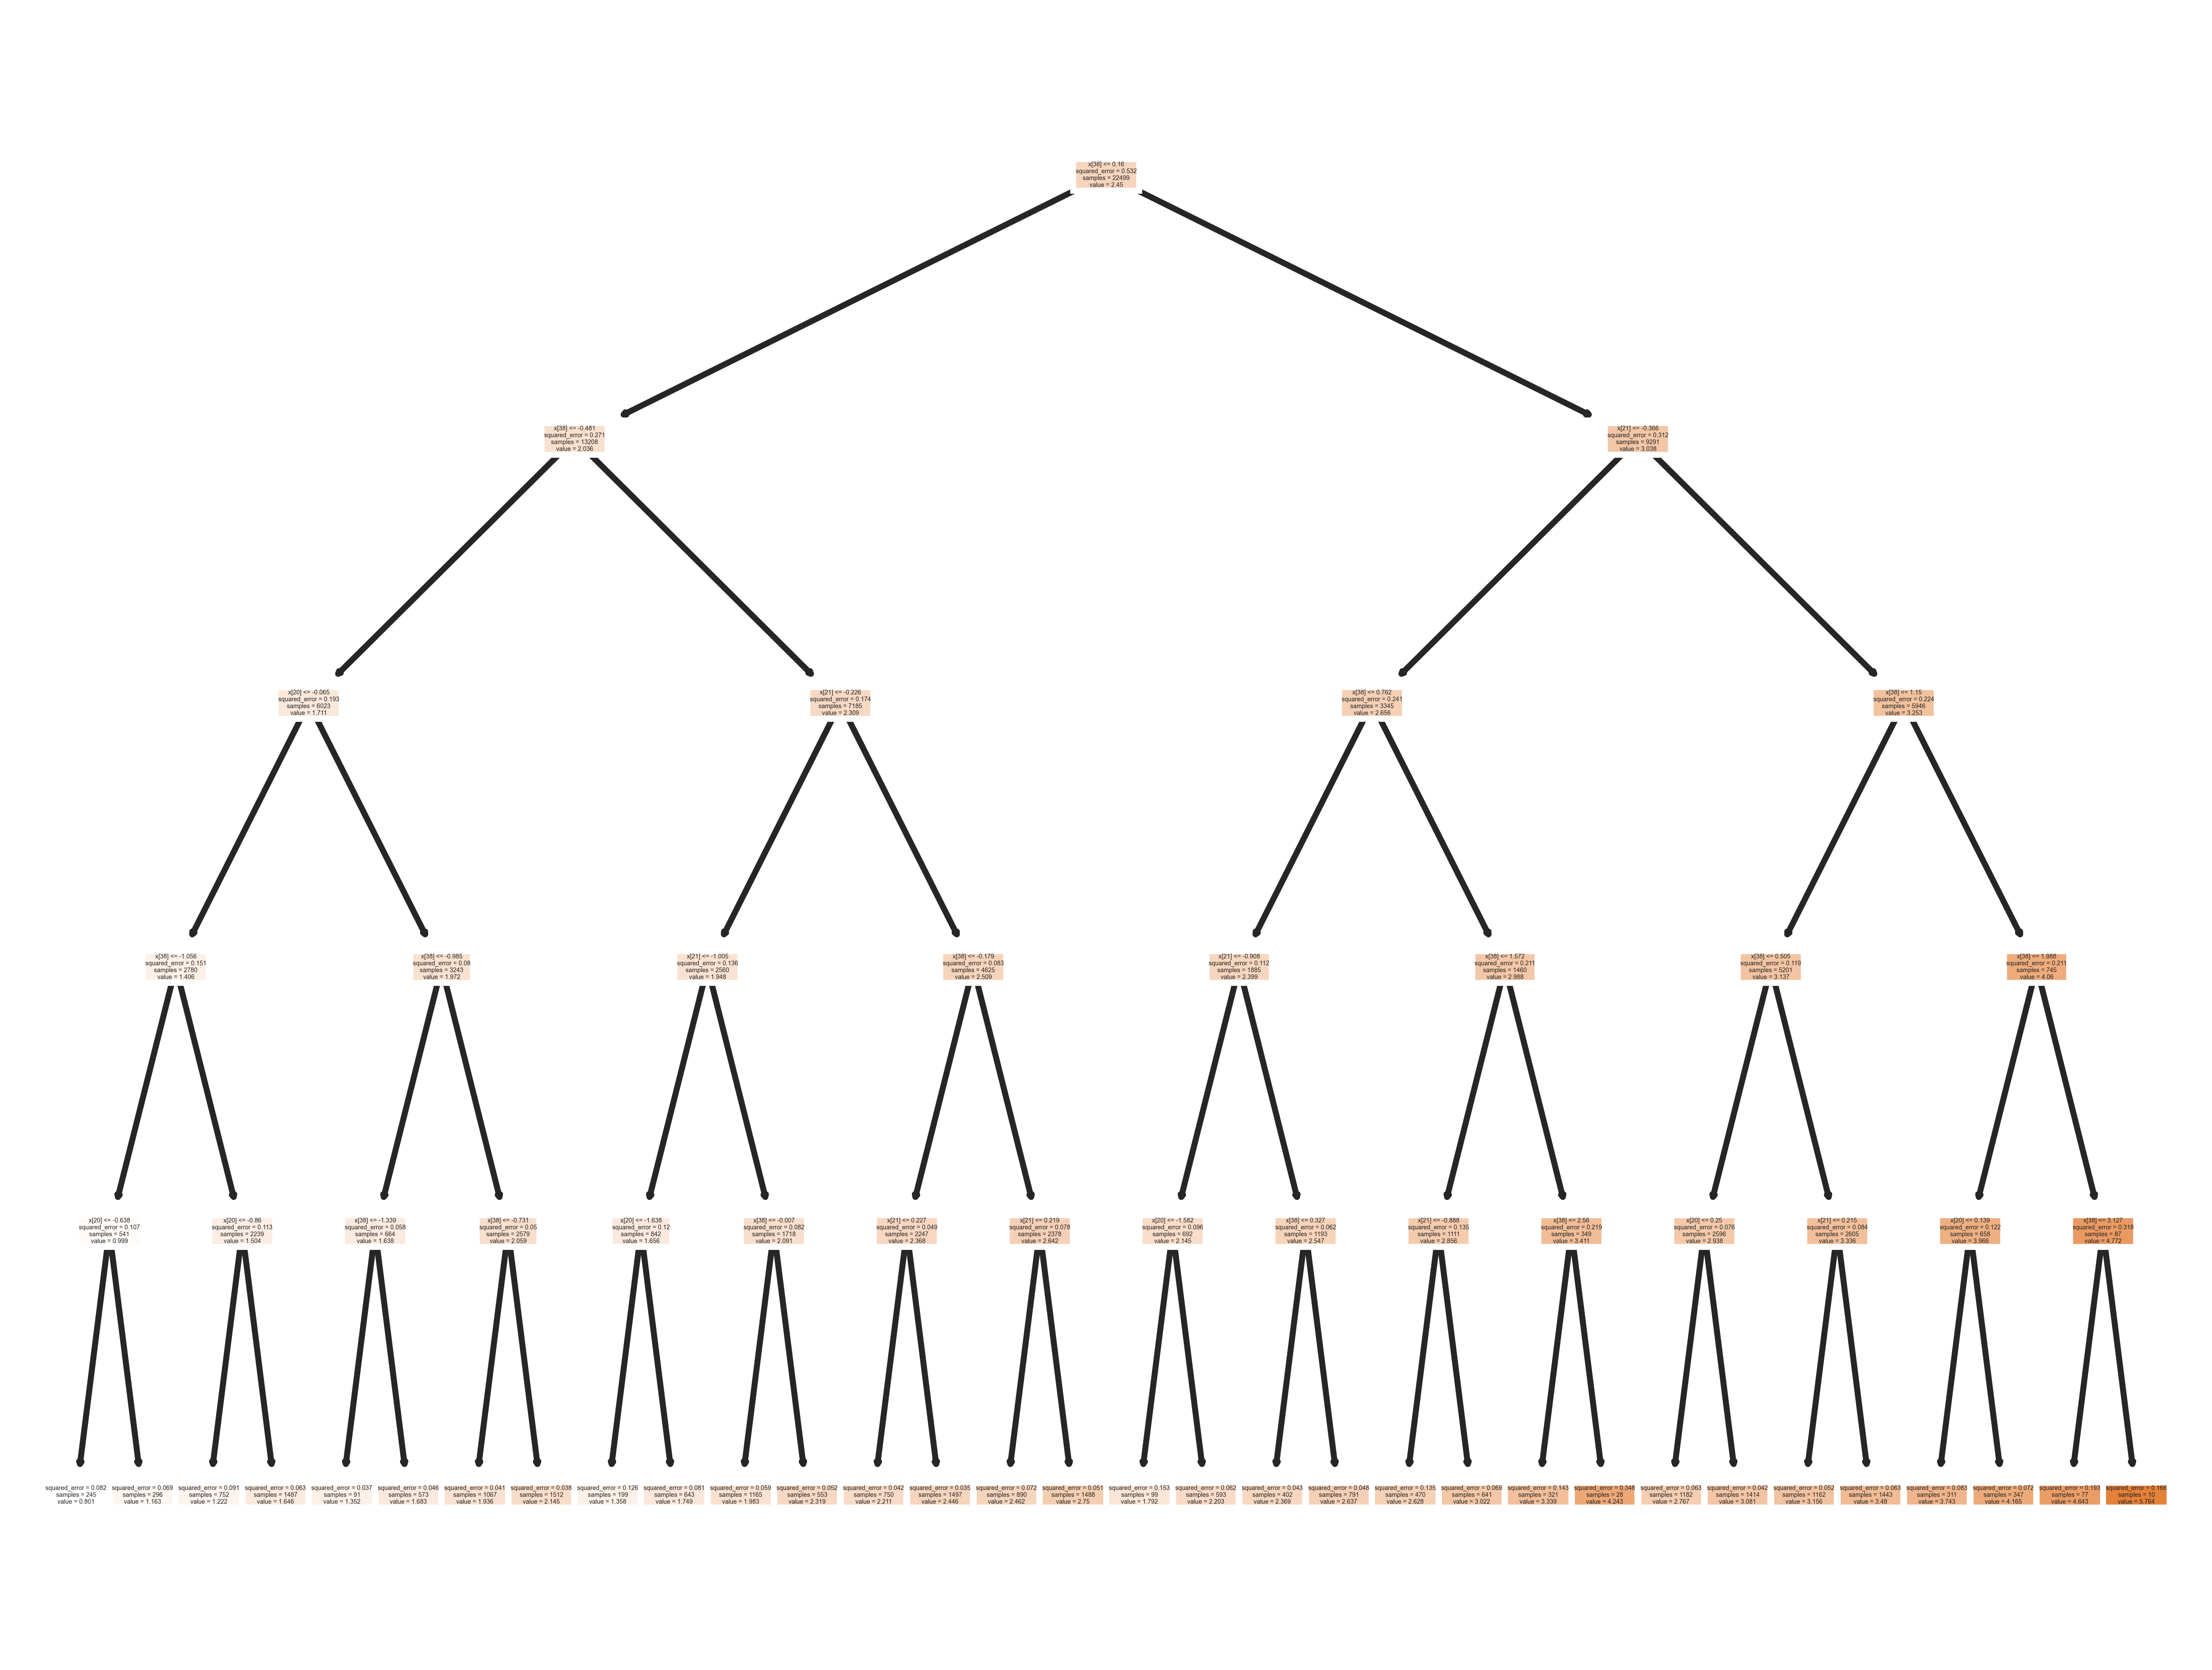

In [7]:
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train, y_train)
plt.figure(dpi=1000)
_ = plot_tree(tree, filled=True)

In [8]:
def criterion(pred, y):
    t_pred = np.exp(pred) - 1
    t_y = np.exp(y) - 1
    dy = np.abs(t_pred - t_y) / t_y
    mape = np.sum(dy) / len(t_y)
    acc = len(dy[dy <= 0.05]) / len(t_y)
    return 0.2 * (1 - mape) + 0.8 * acc

In [9]:
score_criterion = make_scorer(criterion, greater_is_better=True)

1. Linear Regression

In [10]:
score = np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv=10, scoring=score_criterion))
result_dic['Linear Regression'] = (score, None)
score

0.37749843640824976

2. Ridge

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10] END ..alpha=1e-05;, score=(train=0.379, test=0.380) total time=   0.0s
[CV 2/10] END ..alpha=1e-05;, score=(train=0.378, test=0.394) total time=   0.0s
[CV 3/10] END ..alpha=1e-05;, score=(train=0.380, test=0.377) total time=   0.0s
[CV 4/10] END ..alpha=1e-05;, score=(train=0.379, test=0.390) total time=   0.0s
[CV 5/10] END ..alpha=1e-05;, score=(train=0.379, test=0.371) total time=   0.0s
[CV 6/10] END ..alpha=1e-05;, score=(train=0.378, test=0.389) total time=   0.0s
[CV 7/10] END ..alpha=1e-05;, score=(train=0.379, test=0.368) total time=   0.0s
[CV 8/10] END ..alpha=1e-05;, score=(train=0.379, test=0.372) total time=   0.0s
[CV 9/10] END ..alpha=1e-05;, score=(train=0.380, test=0.369) total time=   0.0s
[CV 10/10] END .alpha=1e-05;, score=(train=0.380, test=0.367) total time=   0.0s
[CV 1/10] END alpha=1.3894954943731388e-05;, score=(train=0.379, test=0.380) total time=   0.0s
[CV 2/10] END alpha=1.389495494

0.37778805292409867

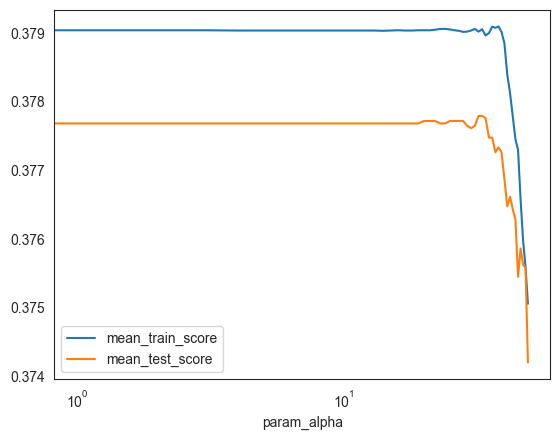

In [11]:
param_grid = {'alpha': np.logspace(-5, 2, 50)}
grid = GridSearchCV(Ridge(), param_grid, cv=10, return_train_score=True, verbose=3, scoring=score_criterion)
grid.fit(X_train, y_train)
plt.figure(dpi=100)
results = pd.DataFrame(grid.cv_results_)

results.plot('param_alpha', 'mean_train_score', ax=plt.gca())
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())

# gca - get current ax
plt.legend()
plt.xscale("log")

print(grid.best_params_)

score = np.mean(cross_val_score(Ridge(alpha=grid.best_params_['alpha']), X_train, y_train, cv=10, scoring=score_criterion))
result_dic['Ridge'] = (score, grid.best_params_['alpha'])

score

In [12]:
parameters = {'alpha': 0.5179474679231213}
model = Ridge(**parameters)
model.fit(X_train, y_train)

Ridge(alpha=0.5179474679231213)

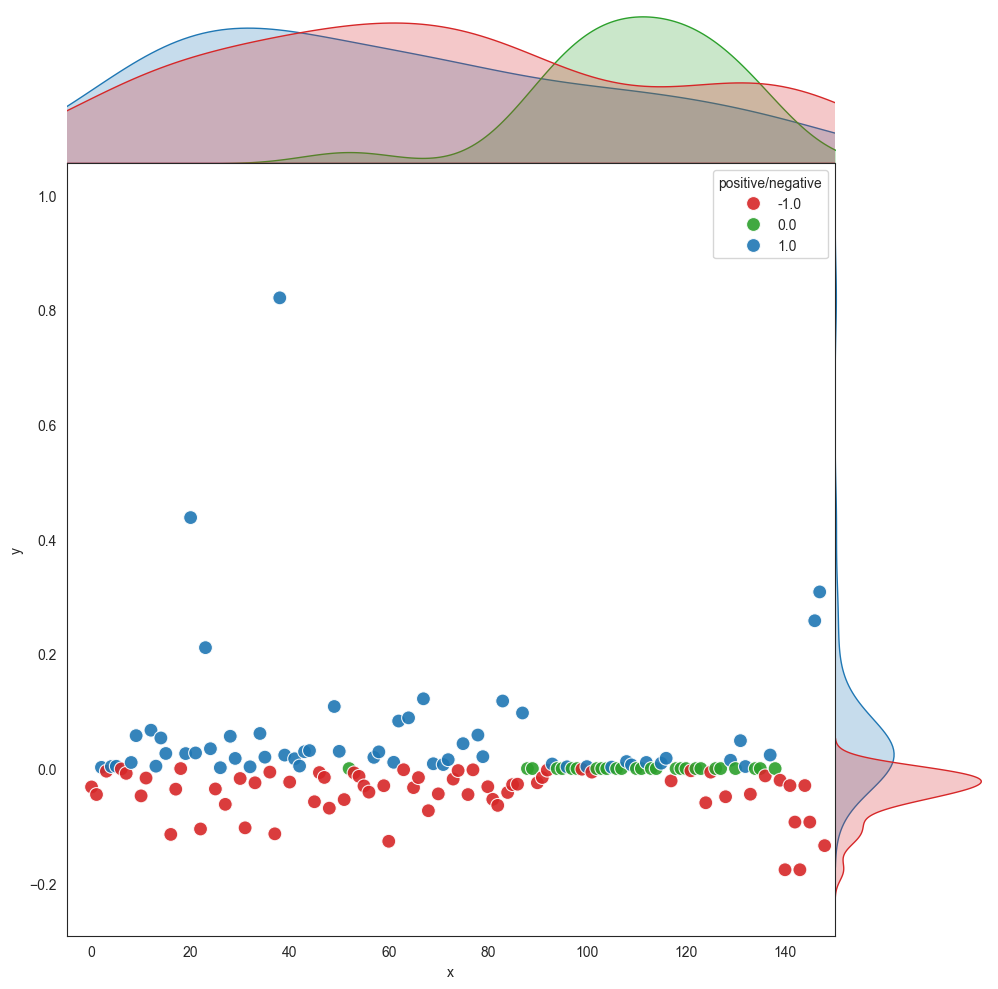

In [13]:
x = [i for i in range(X_train.shape[1])]
y = model.coef_
c_sign = np.sign(model.coef_)

palette = {
    -1: 'tab:red',
    0: 'tab:green',
    1: 'tab:blue',
}

plt_df = pd.DataFrame({'x': x, 'y': y, 'positive/negative': c_sign})
g = sns.jointplot(x = 'x', y = 'y', data = plt_df, xlim = (-5, 150), height = 10, hue='positive/negative', space=0, palette=palette, s = 100, alpha = 0.9)


3. Lasso

In [14]:
# # Takes Too long to run!
# param_grid = {'alpha': np.logspace(-6, -1, 5)}
# grid = GridSearchCV(Lasso(), param_grid, cv=5, return_train_score=True, verbose=3, scoring=score_criterion)
# grid.fit(X_train, y_train)
# plt.figure(dpi=100)
# results = pd.DataFrame(grid.cv_results_)
# results.plot('param_alpha', 'mean_train_score', ax=plt.gca())
# results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
# # gca - get current ax
# plt.legend()
# plt.xscale("log")

# print(grid.best_params_)

# score = np.mean(cross_val_score(Lasso(alpha=grid.best_params_['alpha']), X_train, y_train, cv=10, scoring=score_criterion))
# result_dic['Lasso'] = (score, grid.best_params_['alpha'])
# score

In [15]:
parameters = {'alpha': 1.778279410038923e-05}
model = Lasso(**parameters)
model.fit(X_train, y_train)

Lasso(alpha=1.778279410038923e-05)

In [16]:
x = [i for i in range(X_train.shape[1])]
y = model.coef_
c_sign = np.sign(model.coef_)

palette = {
    -1: 'tab:red',
    0: 'tab:green',
    1: 'tab:blue',
}

plt_df = pd.DataFrame({'x': x, 'y': y, 'positive/negative': c_sign})
g = sns.jointplot(x, y, data=plt_df, xlim = (-5, 150), height = 10, hue='positive/negative', space=0, palette=palette, s = 100, alpha = 0.9)


TypeError: jointplot() got multiple values for argument 'data'

In [ ]:
model.coef_

array([-3.18047124e-02, -4.55949562e-02,  0.00000000e+00, -5.63635513e-03,
        1.68863537e-03,  2.40678940e-03, -2.33542329e-03, -1.07910507e-02,
        8.09403079e-03,  5.22303794e-02, -4.77286752e-02, -0.00000000e+00,
        4.04433276e-02, -2.02568157e-02,  2.70428944e-02,  0.00000000e+00,
       -1.27961402e-01, -0.00000000e+00,  2.45250548e-04,  2.77606250e-02,
        4.38275446e-01,  2.91390083e-02, -1.01007605e-01,  2.12921739e-01,
        3.81577696e-02, -3.15671903e-02,  3.93881527e-03, -5.84645813e-02,
        5.49606524e-02,  2.10644133e-02, -1.33609174e-02, -9.89770895e-02,
        0.00000000e+00, -2.33855815e-02,  5.91828968e-02,  2.00227821e-02,
       -6.35749082e-03, -1.14206849e-01,  8.21970345e-01,  3.87381172e-02,
       -1.42583441e-17,  1.66586660e-02,  0.00000000e+00,  2.56563994e-02,
        4.51137707e-03, -5.72632038e-02, -6.67946731e-03, -0.00000000e+00,
       -6.12796772e-02,  1.75870490e-02,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -

4. XGBoost

In [ ]:
def mape(dtrain, preds):
    d = preds - dtrain
    h = 1
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

parameters = {
    'max_depth'        : np.arange(11, 14),
    'n_estimators'     : np.arange(200, 250, 10),
    'gamma'            : [0],
    'eta'              : [0.1],
    'objective'        : [mape],
}

grid = GridSearchCV(xgb.XGBRegressor(), parameters, cv=10, return_train_score=True, scoring=score_criterion, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)

score = np.mean(cross_val_score(xgb.XGBRegressor(**grid.best_params_), X_train, y_train, cv=10, scoring=score_criterion))
result_dic['XGBRegressor'] = (score, grid.best_params_)
score

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV 1/10] END eta=0.1, gamma=0, max_depth=11, n_estimators=200, objective=<function mape at 0x000002088DFA4040>;, score=(train=0.958, test=0.524) total time=   3.0s
[CV 2/10] END eta=0.1, gamma=0, max_depth=11, n_estimators=200, objective=<function mape at 0x000002088DFA4040>;, score=(train=0.945, test=0.529) total time=   2.7s
[CV 3/10] END eta=0.1, gamma=0, max_depth=11, n_estimators=200, objective=<function mape at 0x000002088DFA4040>;, score=(train=0.948, test=0.535) total time=   2.7s
[CV 4/10] END eta=0.1, gamma=0, max_depth=11, n_estimators=200, objective=<function mape at 0x000002088DFA4040>;, score=(train=0.953, test=0.529) total time=   2.8s
[CV 5/10] END eta=0.1, gamma=0, max_depth=11, n_estimators=200, objective=<function mape at 0x000002088DFA4040>;, score=(train=0.959, test=0.534) total time=   2.8s
[CV 6/10] END eta=0.1, gamma=0, max_depth=11, n_estimators=200, objective=<function mape at 0x000002088DFA4040>;

In [ ]:
parameters = {'eta': 0.1, 'eval_metric': 'mae', 'gamma': 0.1, 'max_depth': 13, 'n_estimators': 190}
model = xgb.XGBRegressor(**parameters)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.1, eval_metric='mae', gamma=0.1, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=13,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=20, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

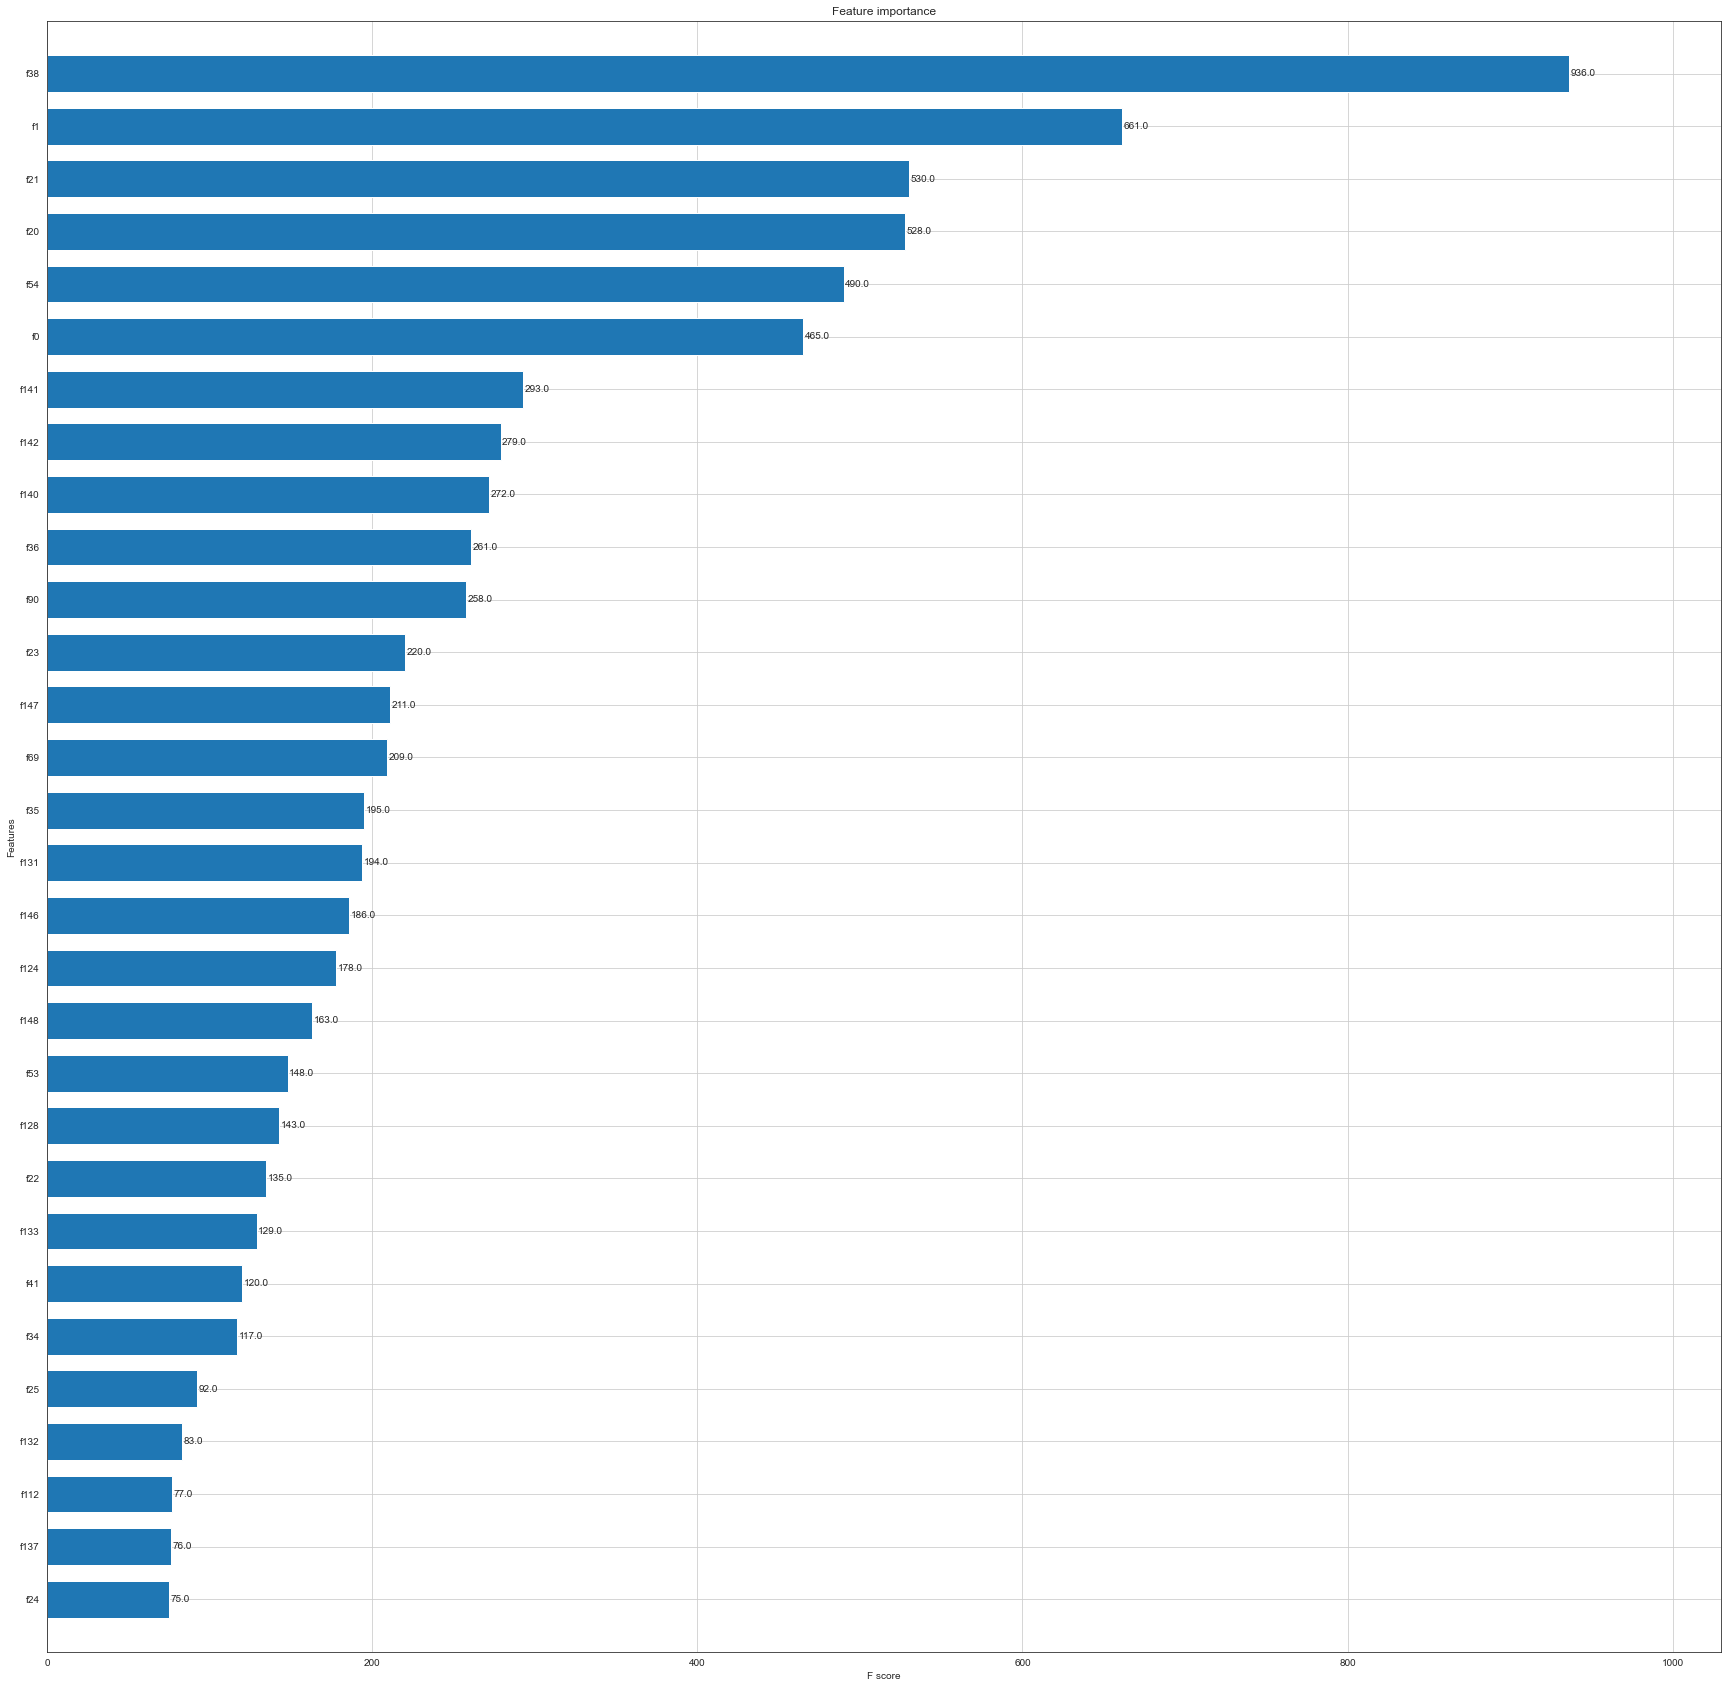

In [ ]:
plt.rcParams["figure.figsize"] = (30, 30)
xgb.plot_importance(model, max_num_features=30, height=0.7)
plt.show()

5. LGB

In [ ]:
parameters = {
    'metric': ['l1'],
    "max_depth": np.arange(16, 20),
    "num_leaves": np.arange(50, 54),  
}

grid = GridSearchCV(lgb.LGBMRegressor(), parameters, cv=10, return_train_score=True, scoring=score_criterion, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)

score = np.mean(cross_val_score(lgb.LGBMRegressor(**grid.best_params_), X_train, y_train, cv=10, scoring=score_criterion))
result_dic['LGBMRegressor'] = (score, grid.best_params_)
score

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END max_depth=16, metric=l1, num_leaves=50;, score=(train=0.559, test=0.496) total time=   0.4s
[CV 2/10] END max_depth=16, metric=l1, num_leaves=50;, score=(train=0.549, test=0.525) total time=   0.2s
[CV 3/10] END max_depth=16, metric=l1, num_leaves=50;, score=(train=0.554, test=0.515) total time=   0.2s
[CV 4/10] END max_depth=16, metric=l1, num_leaves=50;, score=(train=0.555, test=0.508) total time=   0.2s
[CV 5/10] END max_depth=16, metric=l1, num_leaves=50;, score=(train=0.554, test=0.505) total time=   0.2s
[CV 6/10] END max_depth=16, metric=l1, num_leaves=50;, score=(train=0.556, test=0.506) total time=   0.2s
[CV 7/10] END max_depth=16, metric=l1, num_leaves=50;, score=(train=0.556, test=0.503) total time=   0.2s
[CV 8/10] END max_depth=16, metric=l1, num_leaves=50;, score=(train=0.559, test=0.510) total time=   0.2s
[CV 9/10] END max_depth=16, metric=l1, num_leaves=50;, score=(train=0.553, test=0.516) to

0.5135302890218749

In [ ]:
parameters = {'max_depth': 17, 'metric': 'l1', 'num_leaves': 52}
model = lgb.LGBMRegressor(**parameters)
model.fit(X_train, y_train)

LGBMRegressor(max_depth=17, metric='l1', num_leaves=52)

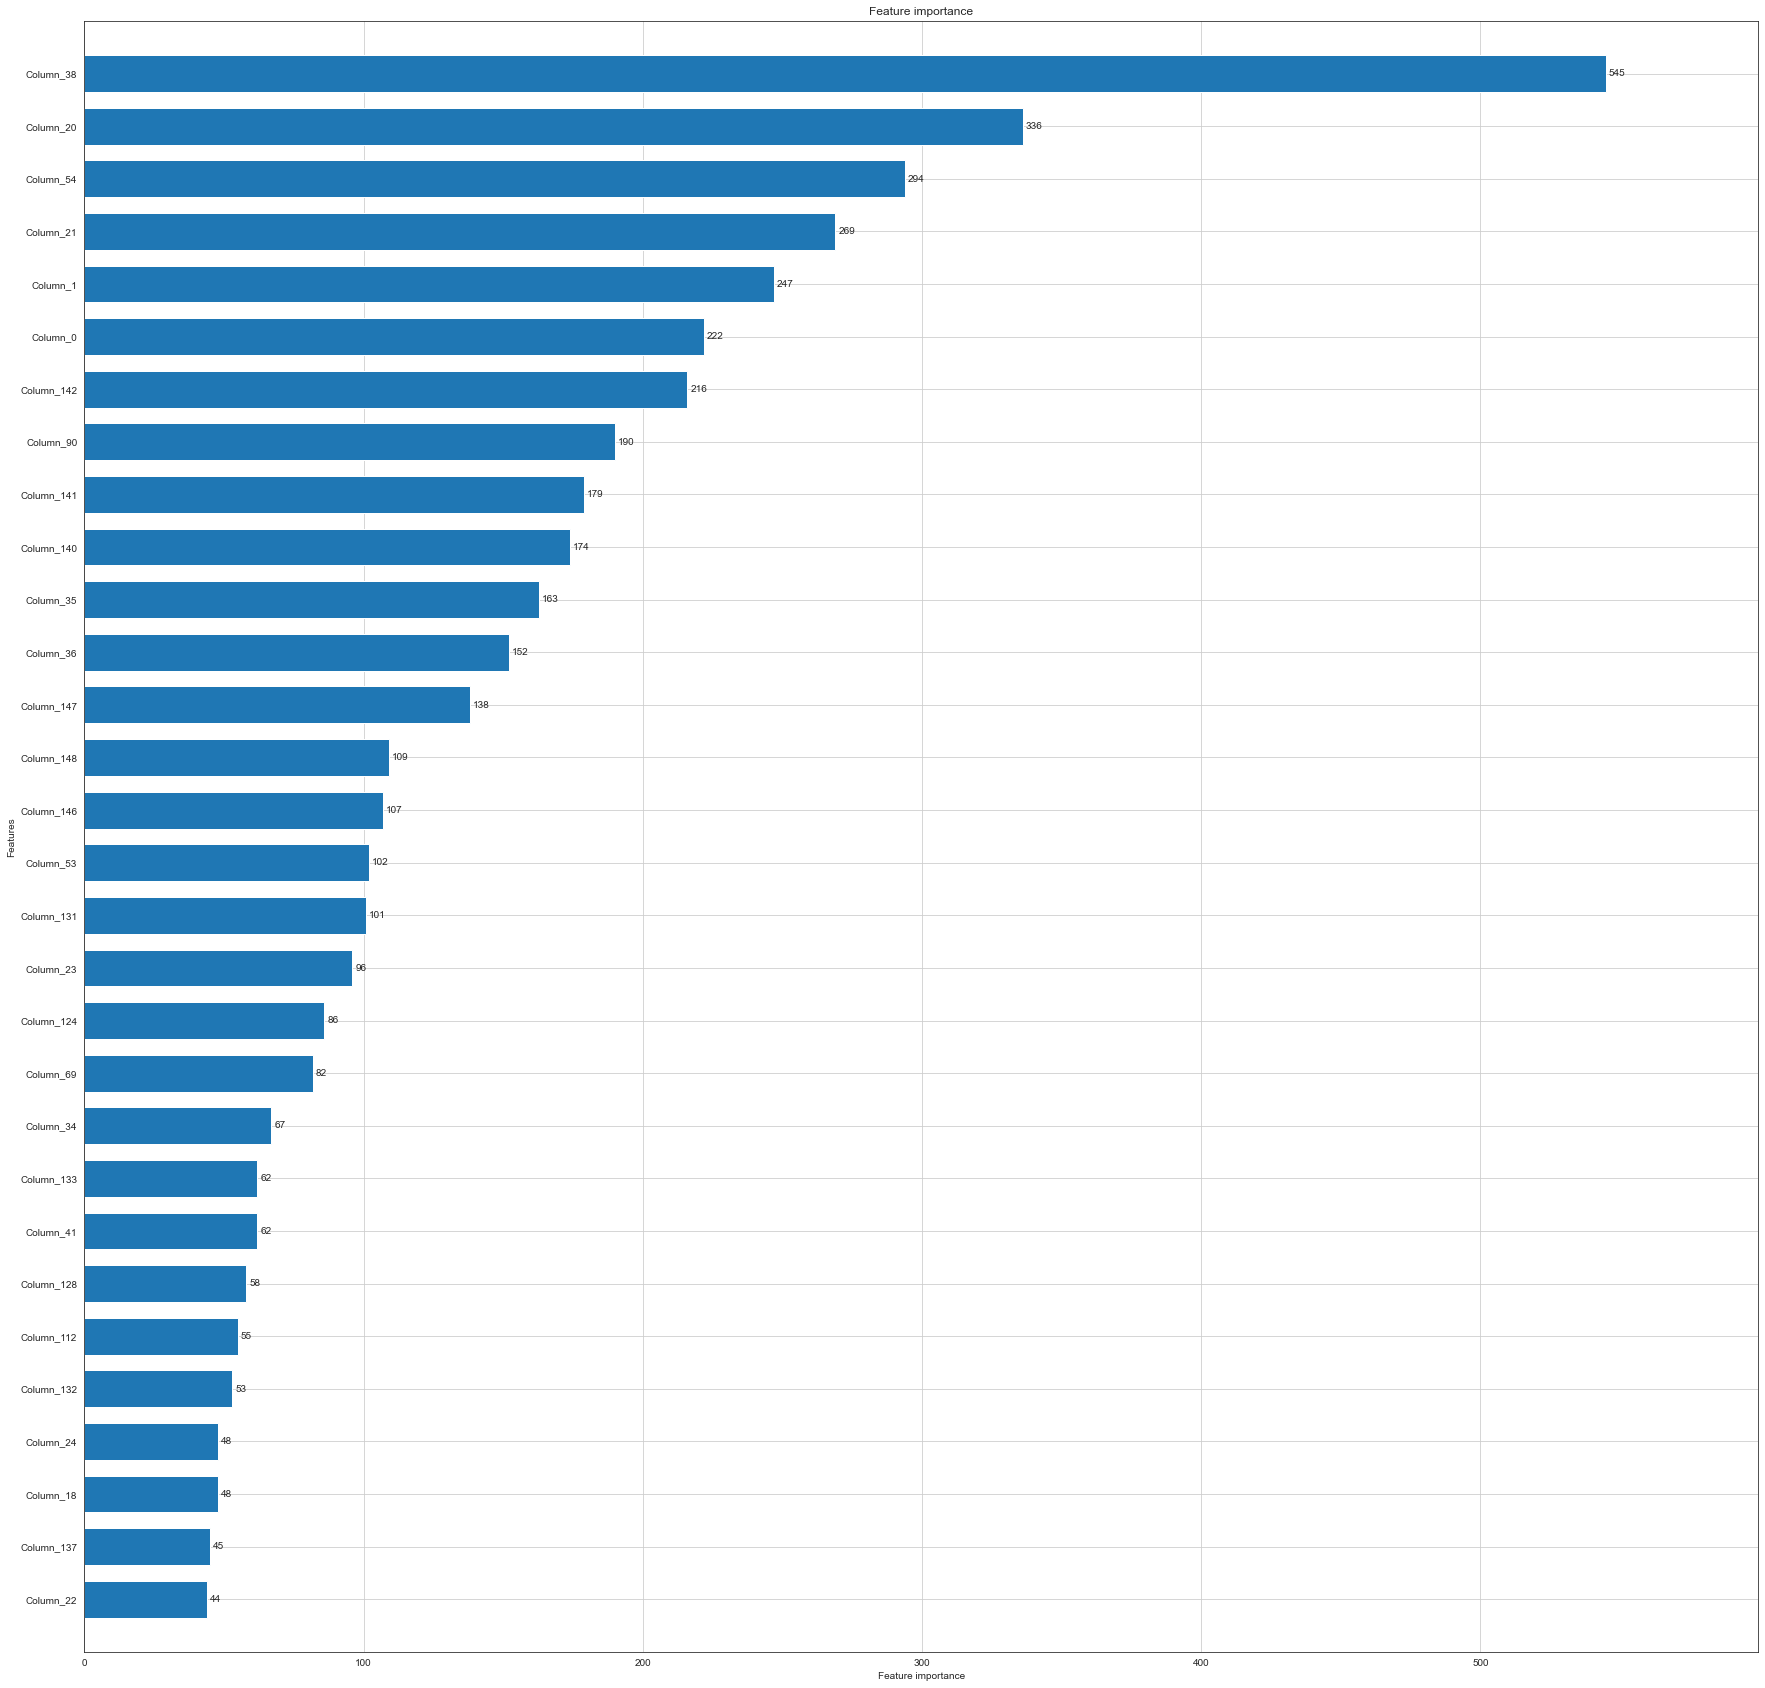

In [ ]:
plt.rcParams["figure.figsize"] = (30, 30)
lgb.plot_importance(model, max_num_features=30, height=0.7)
plt.show()

6. SVR

In [ ]:
# parameters = {
#     "kernel"           : ['rbf'],
#     'degree'           : [2, 3],
#     "gamma"            : ['auto'],
#     'tol'              : [0.001, 0.0005, 0.0001],
#     'C'                : [1, 0.5],
# }

# grid = GridSearchCV(SVR(), parameters, cv=5, return_train_score=True, scoring=score_criterion, verbose=3)
# grid.fit(X_train, y_train)
# print(grid.best_params_)

# score = np.mean(cross_val_score(SVR(), X_train, y_train, cv=5, scoring=score_criterion))
# result_dic['SVR'] = (score, 'default')
# score

model = SVR()
model.fit(X_train, y_train)
score = criterion(model.predict(X_test), y_test)
result_dic['SVR'] = (score, 'default')
score

0.47666389296102224

7. GBR

In [ ]:
para = {
    'alpha': 0.99,
    'learning_rate': 0.1,
    'loss': 'lad',
    'max_depth': 9,
    'max_features': 0.6000000000000001,
    'min_samples_leaf': 14,
    'min_samples_split': 10,
    'n_estimators': 100,
    'subsample': 1.0
}

model = GradientBoostingRegressor(
    alpha=0.99,
    learning_rate=0.1,
    loss='lad',
    max_depth=9,
    max_features=0.6000000000000001,
    min_samples_leaf=14,
    min_samples_split=10,
    n_estimators=100,
    subsample=1.0
)

score = np.mean(cross_val_score(model, X_train, y_train, cv=10, scoring=score_criterion))
result_dic['GBR'] = (score, para)
score

0.5337867417411112

In [ ]:
# result_dic = {'Linear Regression': (np.nan, None),
#     'Ridge': (0.3777880529240987, 0.5179474679231213),
#     'Lasso': (0.37628290072954884, 1.778279410038923e-05),
#     'XGBRegressor': (0.5248582718245366,
#     {'eta': 0.1,
#     'eval_metric': 'mae',
#     'gamma': 0.1,
#     'max_depth': 13,
#     'n_estimators': 190}),
#     'LGBMRegressor': (0.5135302890218749,
#     {'max_depth': 17, 'metric': 'l1', 'num_leaves': 52}),
#     'SVR': (0.4766638929610223, 'default'),
#     'GBR': (0.5345630554391204,
#     {'alpha': 0.99,
#     'learning_rate': 0.1,
#     'loss': 'lad',
#     'max_depth': 9,
#     'max_features': 0.6000000000000001,
#     'min_samples_leaf': 14,
#     'min_samples_split': 10,
#     'n_estimators': 100,
#     'subsample': 1.0})
# }

result_dic

{'Linear Regression': (nan, None),
 'Ridge': (0.3777880529240987, 0.5179474679231213),
 'XGBRegressor': (0.5292780685635661,
  {'eta': 0.1,
   'gamma': 0,
   'max_depth': 12,
   'n_estimators': 230,
   'objective': <function __main__.mape(dtrain, preds)>}),
 'LGBMRegressor': (0.5135302890218749,
  {'max_depth': 17, 'metric': 'l1', 'num_leaves': 52}),
 'SVR': (0.47666389296102224, 'default'),
 'GBR': (0.5337867417411112,
  {'alpha': 0.99,
   'learning_rate': 0.1,
   'loss': 'lad',
   'max_depth': 9,
   'max_features': 0.6000000000000001,
   'min_samples_leaf': 14,
   'min_samples_split': 10,
   'n_estimators': 100,
   'subsample': 1.0})}

6. Stacking Models: Linear Combination

In [ ]:
model_0 = make_pipeline(
    StackingEstimator(estimator=xgb.XGBRegressor(learning_rate=0.001,
                                                    max_depth=1,
                                                    min_child_weight=2,
                                                    n_estimators=100,
                                                    objective='reg:squarederror',
                                                    subsample=0.6500000000000001)),
    RandomForestRegressor(bootstrap=False,
                            max_features=0.5,
                            min_samples_leaf=2,
                            min_samples_split=2,)
)

model_1 = GradientBoostingRegressor(alpha=0.99,
                                    learning_rate=0.1,
                                    loss='lad',
                                    max_depth=9,
                                    max_features=0.6,
                                    min_samples_leaf=14,
                                    min_samples_split=10,
                                    n_estimators=100,
                                    subsample=1.0)


model_2 = RandomForestRegressor(bootstrap=False,
                                max_features=0.5,
                                min_samples_leaf=2,
                                min_samples_split=2,
                                n_estimators=100
                                )

# models = [model_1, model_2]
models = [model_0, model_1, model_2]

In [ ]:
# Train each model
pred_trains = np.empty((y_train.shape[0],1), int)
for model in models:
    model.fit(X_train, y_train)
    pred_y = model.predict(X_train).reshape(y_train.shape[0],1)
    pred_trains = np.append(pred_trains, pred_y, axis=1)
pred_trains = pred_trains[:,1:]

In [ ]:
# Model Stacking
combine_model = LinearRegression(fit_intercept=False)
combine_model.fit(pred_trains, y_train)
print(combine_model.coef_)
print(combine_model.intercept_)
print(combine_model.score(pred_trains, y_train))

[ 0.38691786 -0.15904954  0.77221146]
0.0
0.9993550386256556


In [ ]:
# Get individual prediction
pred_tests = np.empty((y_test.shape[0],1), int)
for model in models:
    print(model)
    pred_y= model.predict(X_test).reshape(y_test.shape[0],1)
    print('score', criterion(pred_y.flatten(), y_test.flatten()))
    print()
    pred_tests = np.append(pred_tests, pred_y, axis=1)
pred_tests = pred_tests[:,1:]

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=XGBRegressor(base_score=0.5,
                                                          booster='gbtree',
                                                          colsample_bylevel=1,
                                                          colsample_bynode=1,
                                                          colsample_bytree=1,
                                                          enable_categorical=False,
                                                          gamma=0, gpu_id=-1,
                                                          importance_type=None,
                                                          interaction_constraints='',
                                                          learning_rate=0.001,
                                                          max_delta_step=0,
                                                          max_depth=1,
                       

In [ ]:
combine_pred_test = combine_model.predict(pred_tests)
print(combine_model)
criterion(combine_pred_test, y_test)

LinearRegression(fit_intercept=False)


0.5483676749764037

<font size=20> 都是菜鸡

10. Stacking Models by Weighted Average

In [ ]:
model_XGB = make_pipeline(
    StackingEstimator(estimator=xgb.XGBRegressor(learning_rate=0.001,
                                                    max_depth=1,
                                                    min_child_weight=2,
                                                    n_estimators=100,
                                                    objective='reg:squarederror',
                                                    subsample=0.6500000000000001)),
    RandomForestRegressor(bootstrap=False,
                            max_features=0.5,
                            min_samples_leaf=2,
                            min_samples_split=2,)
)


model_GBR = GradientBoostingRegressor(alpha=0.99,
                                    learning_rate=0.1,
                                    loss='lad',
                                    max_depth=9,
                                    max_features=0.6,
                                    min_samples_leaf=14,
                                    min_samples_split=10,
                                    n_estimators=100,
                                    subsample=1.0)


model_RFR = RandomForestRegressor(bootstrap=False,
                                max_features=0.5,
                                min_samples_leaf=2,
                                min_samples_split=2,
                                n_estimators=100
                                )

final_model = [model_XGB, model_GBR, model_RFR]

In [ ]:
# Train each model
pred_trains = np.empty((y_train.shape[0],1), int)
for model in final_model:
    model.fit(X_train, y_train)
    pred_y = model.predict(X_train).reshape(y_train.shape[0],1)
    pred_trains = np.append(pred_trains, pred_y, axis=1)
pred_trains = pred_trains[:,1:]

<Figure size 2160x2160 with 0 Axes>

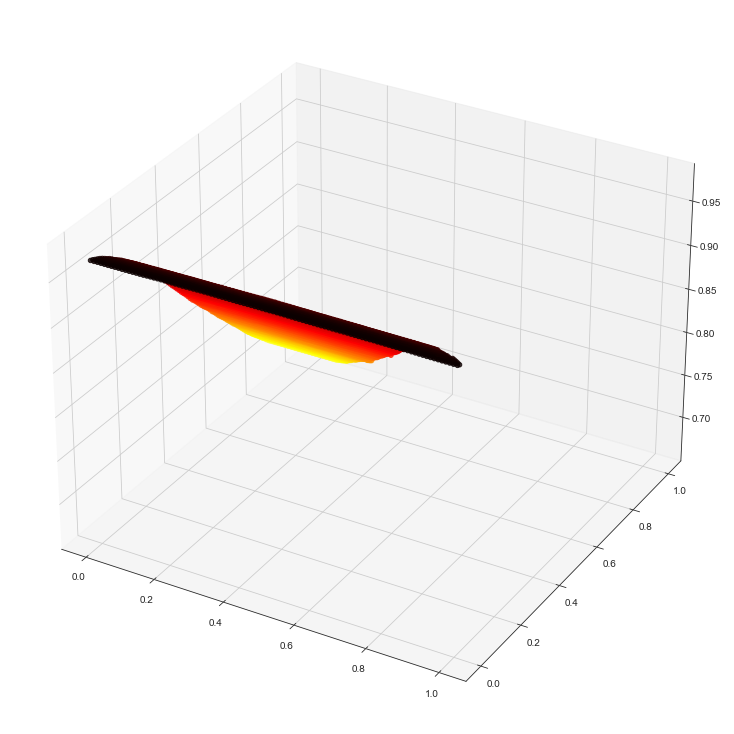

[0.51, 0.0]


0.9699701815385694

In [ ]:
plt.cla()
plt.clf()
plt.rcParams["figure.figsize"] = (10, 10)

if len(final_model) == 2:
    prediction_1 = pred_trains[:,0]
    prediction_2 = pred_trains[:,1]
    xx = prediction_1 - prediction_2
    yy = y_train - prediction_2
else:
    prediction_1 = pred_trains[:,0]
    prediction_2 = pred_trains[:,1]
    prediction_3 = pred_trains[:,2]
    x = []
    y = []
    z = []
    best = [0, 0]
    max_acc = -1
    for w1 in np.arange(0, 1.01, 0.01):
        for w2 in np.arange(0, 1.01 - w1, 0.01):
            final_pred = w1 * prediction_1 + w2 * prediction_2 + (1 - w1 - w2) * prediction_3
            acc = criterion(final_pred, y_train)
            x.append(w1)
            y.append(w2)
            z.append(acc)
            if acc > max_acc:
                best = [w1, w2]
                max_acc = acc
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c = z, alpha = 0.8, cmap=plt.cm.hot_r)
    plt.show()
print(best)
max_acc

In [ ]:
if len(final_model) == 2:
    weighted_model = LinearRegression(fit_intercept=False)
    weighted_model.fit(xx.reshape(-1,1), yy.reshape(-1,1))
    weighted_model.coef_[0,0]

In [ ]:
# Training set acc
if len(final_model) == 2:
    w = weighted_model.coef_[0,0]
    print('XGB:', criterion(prediction_1, y_train))
    print('SGDReg:', criterion(prediction_2, y_train))
    weighted_prediction_train = w * prediction_1 + (1-w) * prediction_2
    print('Combined:', criterion(weighted_prediction_train, y_train))

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=XGBRegressor(base_score=0.5,
                                                          booster='gbtree',
                                                          colsample_bylevel=1,
                                                          colsample_bynode=1,
                                                          colsample_bytree=1,
                                                          enable_categorical=False,
                                                          gamma=0, gpu_id=-1,
                                                          importance_type=None,
                                                          interaction_constraints='',
                                                          learning_rate=0.001,
                                                          max_delta_step=0,
                                                          max_depth=1,
                       

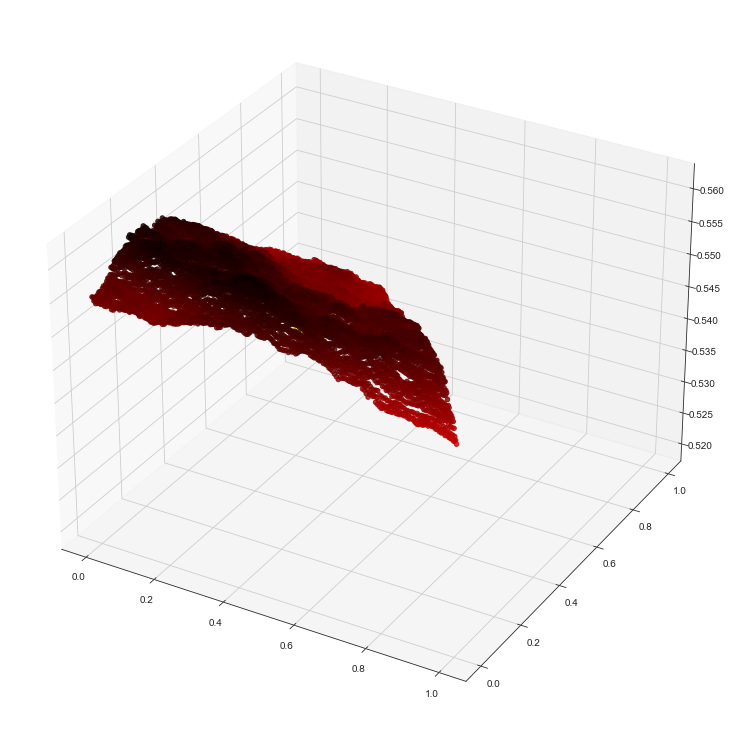

[0.375, 0.11]


0.5608221516907701

In [ ]:
pred_tests = np.empty((y_test.shape[0],1), int)
for model in final_model:
    print(model)
    pred_y= model.predict(X_test).reshape(y_test.shape[0],1)
    print(criterion(y_test, pred_y.flatten()))
    pred_tests = np.append(pred_tests, pred_y, axis=1)
pred_tests = pred_tests[:,1:]

if len(final_model) == 2:
    print("weighted predition")
    weighted_prediction_test = w * pred_tests[:,0] + (1-w) * pred_tests[:,1]
    print(criterion(weighted_prediction_test.flatten(), y_test))
    
else:
    prediction_1 = pred_tests[:,0]
    prediction_2 = pred_tests[:,1]
    prediction_3 = pred_tests[:,2]
    x = []
    y = []
    z = []
    best = [0, 0]
    max_acc = -1
    for w1 in np.arange(0, 1.005, 0.005):
        for w2 in np.arange(0, 1.005 - w1, 0.005):
            final_pred = w1 * prediction_1 + w2 * prediction_2 + (1 - w1 - w2) * prediction_3
            acc = criterion(final_pred, y_test)
            x.append(w1)
            y.append(w2)
            z.append(acc)
            if acc > max_acc:
                best = [w1, w2]
                max_acc = acc
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c = z, alpha = 0.8, cmap=plt.cm.hot_r)
    plt.show()
print(best)
max_acc